# Analyse d'image

Objectif: Travailler avec un échantillon de données d'imagerie médicale au format DICOM et apprendre à les visualiser et à effectuer certaines tâches de base d'analyse d'images médicales, telles que le lissage et la segmentation.

Date: **Dec 06, 2022**

Gilles Cohen | gilles.cohen@univ.lyon1.fr

M2 - UCBL Université Lyon.

<div class="alert alert-block alert-info">
**Note importante**: Le code est assez complexe.  Vous n'êtes pas censé comprendre entièrement le code ci-dessous, mais simplement vous y essayer, afin d'avoir une idée de ce qu'est la manipulation des données d'imagerie médicale.
</div>

## Partie 1: Importation des paquets nécessaires

*Pydicom* est un paquetage Python pour travailler avec les fichiers DICOM. Il nous permet de lire et de manipuler facilement les fichiers DICOM à l'aide de Python.

ITK (Insight Segmentation and Registration Toolkit) est une bibliothèque qui permet le traitement d'images, et elle est largement utilisée pour le développement de programmes de segmentation et d'enregistrement d'images. Ici, nous utiliserons SimpleITK, car il s'agit d'une interface simplifiée d'ITK.

Le module *OS* en Python permet d'utiliser des fonctionnalités dépendantes du système d'exploitation, par exemple pour travailler avec des fichiers et des dossiers.

*NumPy* est un paquetage Python largement utilisé pour travailler avec de grandes données multidimensionnelles (notez qu'ici nous l'utiliserons pour manipuler des données pixel), tandis que *Matplotlib* est une bibliothèque Python pour tracer des données.

Maintenant, on importe les packages. 

In [1]:
import pydicom
import SimpleITK
import os
import matplotlib.pyplot as plt
#%pylab inline

%matplotlib inline
from scipy import ndimage as ndi
from skimage import data, img_as_float,color, img_as_ubyte
from skimage import color, io, filters
from skimage.feature import peak_local_max, canny
from skimage.transform import hough_circle,hough_circle_peaks,hough_line, hough_line_peaks
from skimage.draw import circle_perimeter
from skimage.filters import try_all_threshold, threshold_otsu, threshold_multiotsu

from skimage.morphology import  skeletonize
from skimage.segmentation import chan_vese, felzenszwalb, slic, quickshift, watershed,mark_boundaries
from matplotlib import cm
import numpy as np

from sklearn.metrics import jaccard_score
from skimage.metrics import adapted_rand_error



<br>

## Partie 2: Chargement des données

On va travailler avec un ensemble de données provenant d'un examen IRM de la tête d'un patient. Les images sont capturées sous forme de fichiers DICOM et sont stockées dans un dossier appelé 'MyHead'.  

Exécutez le code dans la cellule suivante pour créer une liste appelée 'lstFilesDCM', qui contient tous les fichiers DICOM dans 'MyHead'. <br> 

On crée d'abord une liste appelée 'lstFilesDCM' qui est initialement vide. on utilise ensuite la fonction *os.walk()* du module OS pour parcourir le dossier MyHead. Pour chaque fichier trouvé dans ce dossier, on vérifie s'il s'agit d'un fichier DICOM, et si c'est le cas, on ajoute son nom étendu (c'est-à-dire le nom du dossier et du fichier) à la liste lstFilesDCM).

In [2]:
PathDicom = "./readonly/MyHead/"
lstFilesDCM = []  # creation liste vide
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # tester si fichiet est DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

Exécutez le code dans la cellule suivante pour obtenir les cinq premiers éléments de la liste 'lstFilesDCM', c'est-à-dire les noms étendus des cinq premiers fichiers DICOM.

In [3]:
lstFilesDCM[:5]

['./readonly/MyHead/MR000000.dcm',
 './readonly/MyHead/MR000001.dcm',
 './readonly/MyHead/MR000002.dcm',
 './readonly/MyHead/MR000003.dcm',
 './readonly/MyHead/MR000004.dcm']

### Lecture d'un fichier DICOM

Exécutez le code dans la cellule suivante pour utiliser la fonction *read_file()* de Pydicom afin de lire le premier fichier DICOM dans lstFilesDCM (identifié comme 'lstFilesDCM[0]'). L'objet résultant est appelé 'HeadDs'. On note qu'on aurait pu l'appeler comme on veut.

In [4]:
HeadDs = pydicom.dcmread(lstFilesDCM[0])

In [5]:

"""
# Assurez-vous que lstFilesDCM contient des fichiers DICOM
if len(lstFilesDCM) > 0:
    HeadDs = pydicom.dcmread(lstFilesDCM[0])  # Lire le premier fichier DICOM
    
    # Afficher certaines métadonnées
    print("Nom du patient :", HeadDs.PatientName)
    print("Date de l'examen :", HeadDs.StudyDate)
    print("Modality :", HeadDs.Modality)

    # Afficher l'image si besoin (en supposant que le fichier contient des données d'image)
    # Pour afficher l'image, vous pouvez utiliser matplotlib
    import matplotlib.pyplot as plt
    
    # Assurez-vous que l'image est présente
    if 'PixelData' in HeadDs:
        # Convertir les données d'image en tableau NumPy
        img = HeadDs.pixel_array
        
        # Afficher l'image
        plt.imshow(img, cmap='gray')
        plt.title('Image IRM')
        plt.axis('off')
        plt.show()
else:
    print("Aucun fichier DICOM trouvé dans la liste.")
"""

'\n# Assurez-vous que lstFilesDCM contient des fichiers DICOM\nif len(lstFilesDCM) > 0:\n    HeadDs = pydicom.dcmread(lstFilesDCM[0])  # Lire le premier fichier DICOM\n    \n    # Afficher certaines métadonnées\n    print("Nom du patient :", HeadDs.PatientName)\n    print("Date de l\'examen :", HeadDs.StudyDate)\n    print("Modality :", HeadDs.Modality)\n\n    # Afficher l\'image si besoin (en supposant que le fichier contient des données d\'image)\n    # Pour afficher l\'image, vous pouvez utiliser matplotlib\n    import matplotlib.pyplot as plt\n    \n    # Assurez-vous que l\'image est présente\n    if \'PixelData\' in HeadDs:\n        # Convertir les données d\'image en tableau NumPy\n        img = HeadDs.pixel_array\n        \n        # Afficher l\'image\n        plt.imshow(img, cmap=\'gray\')\n        plt.title(\'Image IRM\')\n        plt.axis(\'off\')\n        plt.show()\nelse:\n    print("Aucun fichier DICOM trouvé dans la liste.")\n'

### Obtenir les métadonnées

On peut à présent obtenir des métadonnées d'intérêt pour cette image en utilisant les fonctions Pydicom appropriées (par exemple *PatientPosition* ou *Modality*).

Exécutez le code dans la cellule suivante pour obtenir la position du patient par rapport à l'espace de l'équipement d'imagerie.

In [6]:
HeadDs.PatientPosition

'HFS'

*HFS* signifie Head First-Supine. Cela signifie que la tête du patient était placée vers l'avant de l'équipement d'imagerie et qu'elle était orientée vers le haut. 

Exécutez le code dans la cellule suivante pour obtenir la date de début de l'étude. Notez que le format de la date est YYYYMMDD.

In [7]:
HeadDs.StudyDate

'20111110'

Exécutez le code dans la cellule suivante pour obtenir la modalité de l'image. Notez que 'MR' signifie 'résonance magnétique', 'CT' signifie 'tomographie par ordinateur' et 'PT' signifie 'tomographie par émission de positons' (PET).

In [8]:
HeadDs.Modality

'MR'

## Partie 3: Visualisation

Maintenant que l'on a une idée des données d'imagerie avec lesquelles on va travailler, on visualise les données en créant un graphique bidimensionnel. Mais d'abord, on doit extraire certaines informations supplémentaires nécessaires au tracé.

### Préparation pour la visualisation

Afin de tracer les données avec Matplotlib, on doit d'abord i) combiner les données de pixels de tous les fichiers DICOM (c'est-à-dire de toutes les tranches) dans un ensemble de données 3D, et ii) spécifier les axes de coordonnées appropriés

On commence par calculer les dimensions totales de l'ensemble de données 3D combiné. Elles doivent être les suivantes : (nombre de lignes de pixels dans une tranche) x (nombre de colonnes de pixels dans une tranche) x (nombre de tranches) le long des axes cartésiens x, y et z. On appelle les dimensions calculées 'CalcPixelDims'.

In [9]:
CalcPixelDims = (int(HeadDs.Rows), int(HeadDs.Columns), len(lstFilesDCM))

Exécutez le code dans la cellule suivante pour obtenir CalcPixelDims.

In [10]:
CalcPixelDims

(256, 256, 176)

Maintenant qu'on a calculé les dimensions, on peut créer un tableau NumPy 3D pour répondre au premier point abordé ci-dessus. Notez qu'un tableau NumPy est compris comme une grille de valeurs, toutes du même type.
Le code suivant crée un tableau NumPy appelé 'HeadImgArray' qui a la même taille que CalcPixelDims, et qui contient les données de pixels de tous les fichiers DICOM dans lstFilesDCM.

In [11]:
HeadImgArray = np.zeros(CalcPixelDims, dtype=HeadDs.pixel_array.dtype)

for filenameDCM in lstFilesDCM:
    ds = pydicom.dcmread(filenameDCM)
    HeadImgArray[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

In [12]:
# code 


# Définir HeadImgArray avec le bon type de données, à partir de la première image DICOM
HeadImgArray = np.zeros(CalcPixelDims, dtype=HeadDs.pixel_array.dtype)

# Remplir HeadImgArray avec les données de pixels de chaque tranche
for i, filenameDCM in enumerate(lstFilesDCM):  # Utilisez enumerate pour obtenir l'index directement
    ds = pydicom.dcmread(filenameDCM)
    HeadImgArray[:, :, i] = ds.pixel_array  # Assignez la tranche à l'index i

# Vérifiez les dimensions de HeadImgArray
print("Dimensions de HeadImgArray :", HeadImgArray.shape)


Dimensions de HeadImgArray : (256, 256, 176)


Maintenant qu'on a abordé le premier point, on passe à la spécification des axes de coordonnées appropriés.
On utilise les fonctions *PixelSpacing* et *SliceThickness* de Pydicom pour calculer l'espacement entre les pixels sur les trois axes. On appellel'objet résultant 'CalcPixelSpacing'.

In [13]:
CalcPixelSpacing = (float(HeadDs.PixelSpacing[0]), float(HeadDs.PixelSpacing[1]), float(HeadDs.SliceThickness))

Ensuite, on utilise CalcPixelDims et CalcPixelSpacing pour calculer les axes de coordonnées. On n'a pas besoin de comprendre ce que fait ce code. Il suffit de l'exécuter pour calculer x, y et z.

In [14]:
x = np.arange(0.0, (CalcPixelDims[0]+1)*CalcPixelSpacing[0], CalcPixelSpacing[0])
y = np.arange(0.0, (CalcPixelDims[1]+1)*CalcPixelSpacing[1], CalcPixelSpacing[1])
z = np.arange(0.0, (CalcPixelDims[2]+1)*CalcPixelSpacing[2], CalcPixelSpacing[2])

### Visualisation

On peut maintenant tracer les données à l'aide du module pyplot de matplotlib.

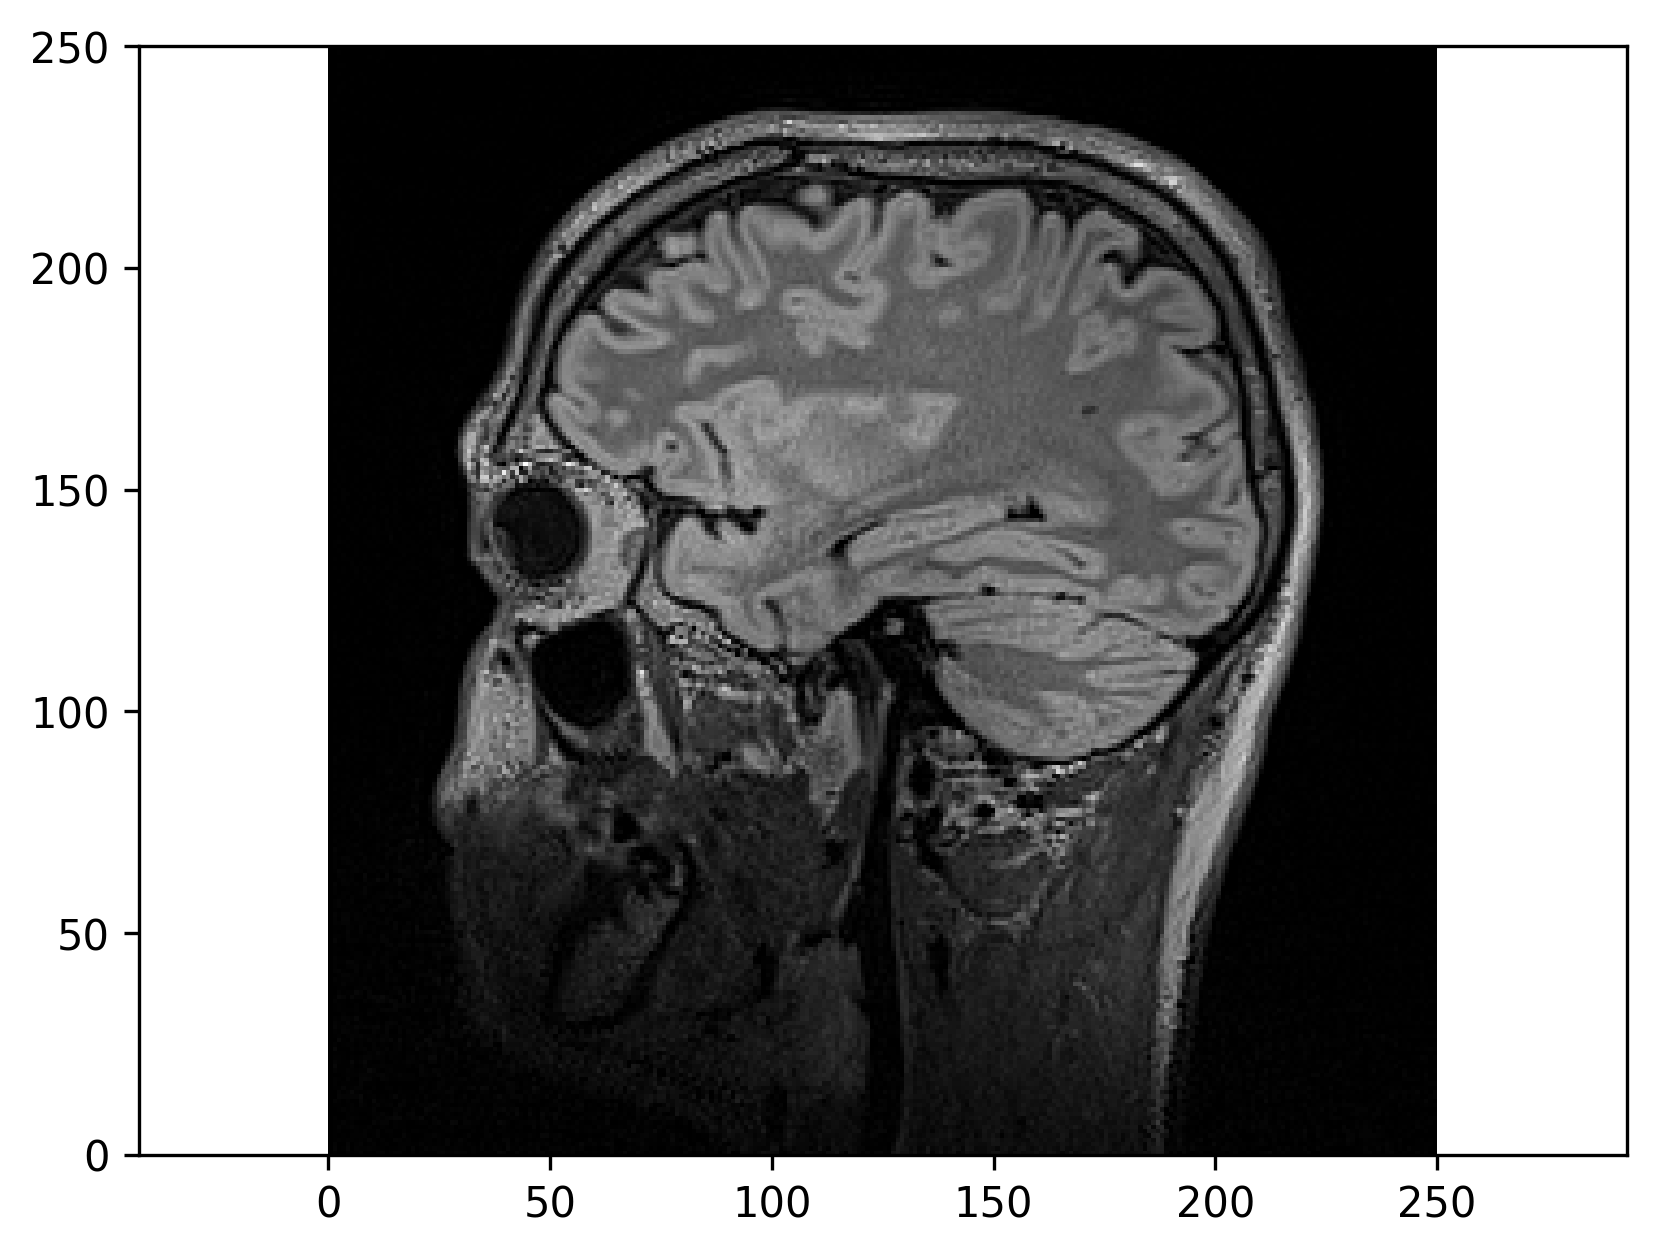

In [15]:
plt.figure(dpi=300)
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())
plt.pcolormesh(x, y, np.flipud(HeadImgArray[:, :, 55]))

## Partie 4: Segmentation

Dans cette partie, on utilise SimpleITK pour segmenter la matière blanche et la matière grise dans les images RM.

### Spécifier une fonction d'aide

On visualise un certain nombre d'images SimpleITK 2D dans cette partie, on définit donc une fonction qui trace rapidement une image SimpleITK 2D avec une carte de couleurs en niveaux de gris et des axes correspondants.

Exécuter le afin de pouvoir utiliser la fonction *sitk_show* par la suite.

In [16]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

### Chargement des données dans SimpleITK

On doit maintenant dire à SimpleITK de lire les fichiers DICOM dans le dossier 'MyHead'. Exécutez le code dans la cellule suivante pour extraire le contenu de l'ensemble de données IRM et créer l'image 3D correspondante appelée 'img3DOriginal'.

In [17]:
reader = SimpleITK.ImageSeriesReader()
filenamesDICOM = reader.GetGDCMSeriesFileNames(PathDicom)
reader.SetFileNames(filenamesDICOM)
img3DOriginal = reader.Execute()

Afin de garder les choses simples, on va segmenter une tranche 2D de l'image 3D (plutôt que l'image 3D entière). Exécutez le code ci-dessous pour spécifier qu'on veut la tranche Z 50 de l'image 3D. On appelle cette tranche "imgOriginal".
Notez qu'on peut demander une tranche Z différente, si on le souhaite.

In [18]:
imgOriginal = img3DOriginal[:,:,50]

### Visualisation les données d'origine

On va maintenant appeler la fonction *sitk_show* pour visualiser les données d'origine.

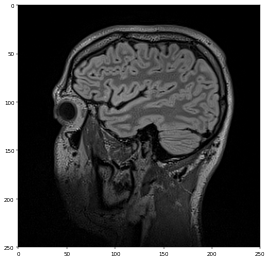

In [19]:
sitk_show(imgOriginal)

### Lissage

Le lissage est le processus qui consiste à réduire le bruit dans une image ou à produire une image moins pixélisée. Le résultat est une image dont les bords nets ou les limites sont préservés et dont le lissage ne se produit que dans une région.

Dans notre cas, on peut voir que les données de l'image originale présentent un bruit assez important, ce qui est assez typique des ensembles de données IRM. On va réduire le bruit, afin de faciliter le processus de segmentation par la suite.

Exécutez le code dans la cellule suivante pour appliquer un filtre d'image de flux de courbure  afin de lisser *imgOriginal*. On appelle l'image résultante 'imgSmooth'.

In [20]:
imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                    timeStep=0.125,
                                    numberOfIterations=5)

Maintenant, voyons les résultats de l'image lissée.

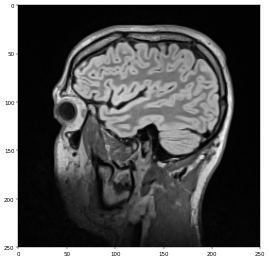

In [21]:
sitk_show(imgSmooth)

### Segmentation avec le filtre ConnectedThreshold

On va maintenant appliquer des techniques de croissance de région pour segmenter la matière blanche et la matière grise de l'image lissée.

#### Segmentation initiale de la matière blanche

Exécutez le code dans la cellule suivante pour appliquer la fonction de filtre *ConnectedThreshold* de SimpleITK à imgSmooth. L'image de la matière blanche segmentée résultante est appelée 'imgWhiteMatter'.

Brève explication : Ce filtre part d'un point de départ dans l'image qu'on sait être de la matière blanche, et examine tous les pixels connectés. Si leurs valeurs se situent dans une plage d'intérêt, ils sont étiquetés comme étant de la matière blanche. Dans notre cas, on  a défini la graine comme étant le point (150, 75), car en inspectant l'image précédente, il semblait que ce point était effectivement de la matière blanche. On a également défini la plage de valeurs entre 130 et 190, car il s'agit approximativement des valeurs que les pixels de matière blanche présentaient (ceci a été inspecté à l'aide d'un logiciel de visualisation DICOM séparé).

In [22]:
lstSeeds = [(150,75)]

imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=lstSeeds, 
                                              lower=130, 
                                              upper=190,
                                              replaceValue=1)

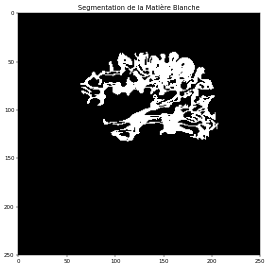

In [23]:
sitk_show(imgWhiteMatter, title="Segmentation de la Matière Blanche")


Ensuite, on veut visualiser le résultat de la segmentation. Si on essaye de visualiser imgWhiteMatter, tout ce que l'on verrait serait une étiquette de couleur blanche sur un fond noir, ce qui donne pas beaucoup d'informations. Cependant, si on utilise une superposition d'étiquettes, on peut voir le résultat de la segmentation de la matière blanche dans une couleur RVB (rouge, vert, bleu) de base. Ici, il s'agit du vert.
Notez qu'avant de superposer imgSmooth et imgWhiteMatter, on doit d'abord manipuler imgSmooth afin de pouvoir mélanger les deux images avec succès. C'est ce que fait le code suivant. L'image résultante est appelée 'imgSmoothInt'.

In [24]:
imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

Utilisons maintenant la fonction *LabelOverlay* de SimpleITK pour superposer 'imgSmoothInt' et 'imgWhiteMatter', et visualisons le résultat.

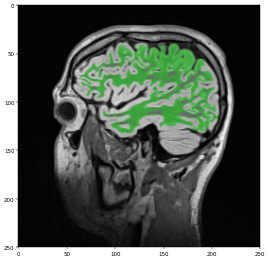

In [25]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

#### Remplissage des trous de la matière blanche segmentée

Comme on peut le voir sur la figure ci-dessus, il y a plusieurs trous dans la matière blanche segmentée. On va rectifier cela en appliquant le remplissage des trous.
Exécutez le code dans la cellule suivante pour utiliser le filtre *VotingBinaryHoleFilling* de SimpleITK pour remplir les trous dans *imgWhiteMatter*. L'image résultante est appelée 'imgWhiteMatterNoHoles'.

In [26]:
imgWhiteMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgWhiteMatter,
                                                          radius=[2]*3,
                                                          majorityThreshold=1,
                                                          backgroundValue=0,
                                                          foregroundValue=1)

On utilise maintenant la fonction *LabelOverlay* de SimpleITK pour superposer 'imgSmoothInt' et le nouveau 'imgWhiteMatterNoHoles', et visualisons le résultat.

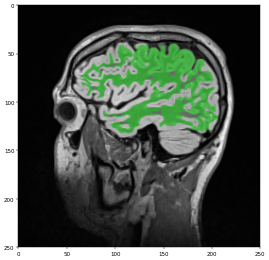

In [27]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))

#### Segmentation et remplissage de la matière grise

On va maintenant répéter le processus pour la matière grise. En d'autres termes, on procède à une segmentation préliminaire, puis on va remplir les trous de la matière grise segmentée. On va ensuite superposer les images 'imgSmoothInt' et 'imgGreyMatterNoHoles' et nous allons visualiser le résultat.

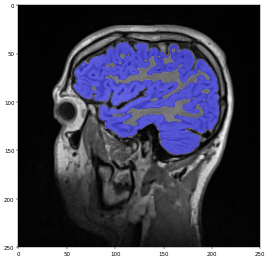

In [28]:
lstSeeds = [(119, 83), (198, 80), (185, 102), (164, 43)]

imgGreyMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                             seedList=lstSeeds, 
                                             lower=150, 
                                             upper=270,
                                             replaceValue=2)

imgGreyMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgGreyMatter,
                                                         radius=[2]*3,
                                                         majorityThreshold=1,
                                                         backgroundValue=0,
                                                         foregroundValue=2) # labelGrayMatter

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgGreyMatterNoHoles))

#### Combiner la matière blanche et la matière grise

Enfin , on combine les deux champs d'étiquettes, en d'autres termes, la matière blanche et la matière grise. On exécute le code ci-dessous, avec les résultats suivants qui sont stockés sous 'imgLabels'.   

In [29]:
imgLabels = imgWhiteMatterNoHoles | imgGreyMatterNoHoles

On utilise maintenant la fonction *LabelOverlay* de SimpleITK pour superposer 'imgSmoothInt' et les 'imgLabels' nouvellement obtenus, et on visualise le résultat.

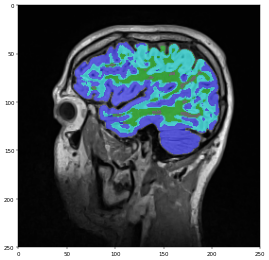

In [30]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

Notez que les étiquettes de couleur cyan sont des régions où la matière blanche et la matière grise se chevauchent à partir du processus de segmentation initial ci-dessus.
La majorité de ces régions devraient en fait faire partie de la matière grise. Exécutez le code dans la cellule suivante pour corriger ce problème, les résultats étant stockés sous 'imgLabels2'.

In [31]:
imgMask = (imgWhiteMatterNoHoles/1) * (imgGreyMatterNoHoles/2)
imgMask2 = SimpleITK.Cast(imgMask, imgWhiteMatterNoHoles.GetPixelIDValue())
imgWhiteMatterNoHoles = imgWhiteMatterNoHoles - (imgMask2*1)
imgLabels2 = imgWhiteMatterNoHoles + imgGreyMatterNoHoles

Maintenant, utilisons la fonction *LabelOverlay* de SimpleITK pour superposer 'imgSmoothInt' et les nouveaux 'imgLabels2', et visualisons le résultat.

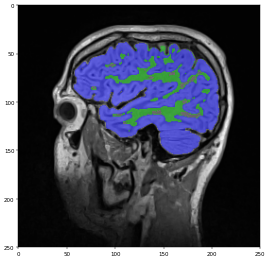

In [32]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels2))

## Partie 5: Pratique segmentation


On rappelle que La segmentation d'image divise les pixels ou voxels d'une image en différents groupes. Par exemple, on peut diviser un ensemble de données de neuroimagerie en parties contenant le cerveau lui-même et en parties non cérébrales (par exemple, arrière-plan, crâne, etc.). De manière générale, la segmentation d'une image permet de savoir où se trouvent les différents objets dans une image et permet ainsi d'analyser séparément les parties de l'image qui contiennent des objets d'intérêt particuliers. 

In [33]:
#from ndslib import load_data
#brain = load_data("bold_volume")
import numpy as np
brain=np.load('brain.npy')

Par souci de simplicité, on examine pour l'instant qu'une seule coupe de données. 
On prend une coupe horizontale à peu près au milieu du cerveau. 
Visualiser l'image peut nous aider à comprendre les défis que la segmentation nous aide à traiter.

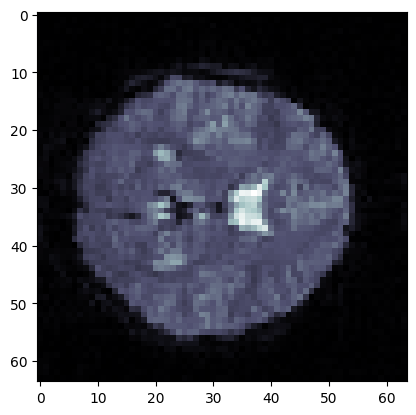

In [34]:
slice10 = brain[:, :, 10]
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
im = ax.imshow(slice10, cmap="bone")

Tout d'abord, une grande partie de l’image se trouve en arrière-plan : l'aire autour de la tête du sujet. 
Si on doit effectuer des calculs statistiques sur les données de chacun des voxels, on aimerait éviter 
de considérer ces voxels. Ce serait une perte de temps. De plus, il y a des parties de l'image qui sont clairement en arrière-plan mais qui contiennent des parties de la tête du sujet ou des parties du cerveau qui n'ont pas d'intérêt. 
Par exemple, on ne veut pas analyser les voxels qui contiennent des parties du crâne et/ou de la peau du sujet qui apparaissent sous forme de lignes lumineuses en haut de la partie de l'image contenant le cerveau. 
On ne souhaite pas non plus analyser les voxels qui se trouvent dans les ventricules, apparaissant ici comme des parties plus lumineuses de l'image. 
Pour pouvoir sélectionner uniquement les voxels qui se trouvent dans le cerveau proprement dit, on doit segmenter l'image en cerveau et non-cerveau. Il existe plusieurs approches différentes pour résoudre ce problème.

## Segmentation basée sur l'intensité

La première et la plus simple approche de segmentation consiste à utiliser la distribution des intensités
de pixels comme base de segmentation. On constate que les parties de l'image qui contiennent 
le cerveau sont plus lumineuses – ont des valeurs d'intensité plus élevées. 
Les parties de l'image qui contiennent l'arrière-plan sont sombres et contiennent des valeurs de faible intensité. 
Une façon de visualiser les valeurs d'intensité dans l'image consiste à utiliser un histogramme. 
Ce code affiche un histogramme des valeurs d'intensité des pixels. On utilise la fonction "hist" de Matplotlib, 
qui attend un tableau unidimensionnel en entrée, donc l'entrée est la représentation "plate" du tableau d'images, 
qui déplie le tableau bidimensionnel en un tableau unidimensionnel.

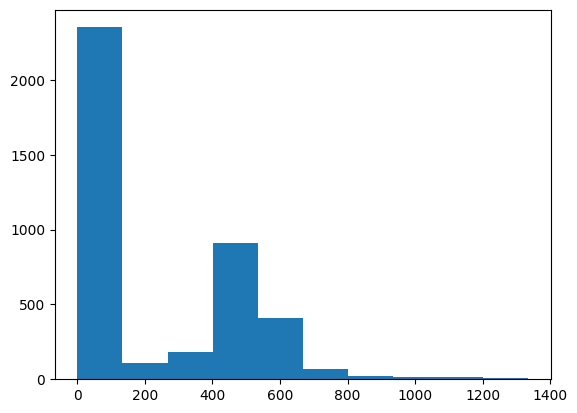

In [35]:
fig, ax = plt.subplots()
p = ax.hist(slice10.flat)

L'histogramme présente deux pics. Un pic aux valeurs d'intensité de pixel inférieures, 
proches de 0, correspond à la partie sombre de l'image qui contient l'arrière-plan, 
et un pic aux valeurs d'intensité plus élevées, correspond à la partie claire de l'image 
qui contient le cerveau.

Une approche de la segmentation consisterait à trouver une valeur seuil. Les pixels avec des valeurs 
inférieures à ce seuil seraient attribués à l'arrière-plan et les valeurs égales ou supérieures à ce seuil 
seraient attribuées au cerveau.

Par exemple, on peut sélectionner l’intensité moyenne des pixels comme seuil. Ici, on affiche l'histogramme 
d'intensité de l'image, ainsi que la valeur moyenne, représentée sous forme de ligne pointillée verticale. 

À quoi ressemblerait une segmentation basée sur cette valeur ?

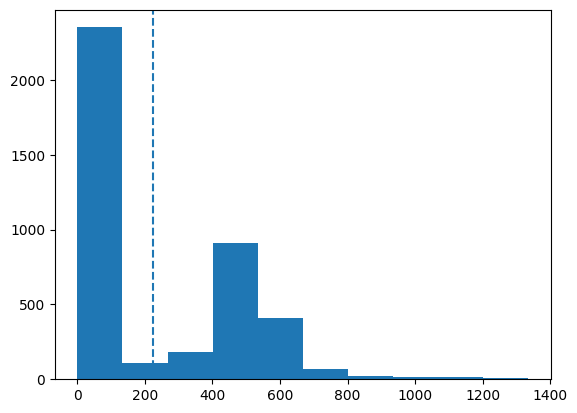

In [36]:
import numpy as np
mean = np.mean(slice10)
fig, ax = plt.subplots()
ax.hist(slice10.flat)
p = ax.axvline(mean, linestyle='dashed')

On commence par créer une image de segmentation contenant tous les zéros. À l'aide de l'indexation booléenne, nous sélectionnons les parties de l'image de segmentation qui correspondent aux parties de l'image cérébrale qui ont des intensités supérieures au seuil et les fixons à 1 (voir aussi {numref} ) boolean_indexing_numpy. Ensuite, on peut afficher cette image au-dessus de notre image cérébrale. Pour s'assurer qu'on peut voir l’image du cerveau à travers l’image de segmentation, on a réglée pour qu’elle soit légèrement transparente. Cela se fait en définissant un paramètre d'imagerie appelé « alpha », qui décrit l'opacité d'une image (où 0 est entièrement transparent et 1,0 est entièrement opaque) sur 0,5. Cela ermet de voir dans quelle mesure la segmentation chevauche l'image cérébrale.

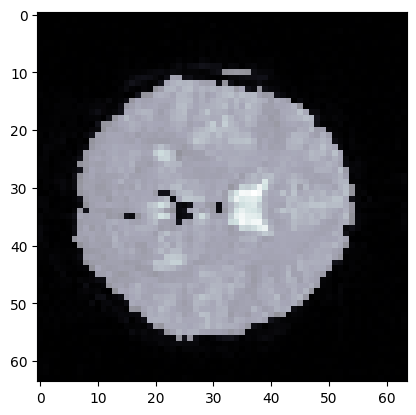

In [37]:
segmentation = np.zeros_like(slice10)
segmentation[slice10 > mean] = 1

fig, ax = plt.subplots()
ax.imshow(slice10, cmap="bone")
im = ax.imshow(segmentation, alpha=0.5)

Avec cette visualisation, on peut voir le cerveau à travers la transparence du masque de segmentation. On peut voir que le seuil moyen est déjà assez efficace pour segmenter les parties de l'image qui contiennent l'arrière-plan, mais il reste encore des parties de l'image qui devraient appartenir à l'arrière-plan et sont toujours considérées comme faisant partie du cerveau. En particulier, des parties du crâne et de la dure-mère sont associées au cerveau, car elles apparaissent brillantes sur l’image. De plus, les ventricules, qui apparaissent plus brillants sur cette image, sont classés comme faisant partie du cerveau. Le défi est de trouver une valeur de seuil qui nous permette une meilleure segmentation.

Une approche classique de ce problème est désormais connue sous le nom de « méthode d'Otsu », du nom de l'ingénieur japonais Nobuyuki Otsu, qui l'a inventée dans les années 1970 {cite} otsu1979. La méthode repose sur un principe simple : trouver un seuil qui minimise la variance des intensités de pixels au sein de chaque classe de pixels (par exemple, cérébraux et non cérébraux). Ce principe repose sur l’idée que les pixels de chacun de ces segments doivent être aussi similaires que possible les uns aux autres et aussi différents que possible de l’autre segment. Il s’avère également qu’il s’agit d’une stratégie très efficace dans de nombreux autres cas où l’on souhaite séparer l’arrière-plan du premier plan (par exemple, du texte sur une page).

On recherche un seuil qui minimiserait la variance totale des intensités de pixels au sein de chaque classe, ou « variance intraclasse ». Cela comporte deux composantes : la première est la variance des intensités des pixels dans les pixels d'arrière-plan, pondérée par la proportion de l'image qui se trouve en arrière-plan. L'autre est la variance des intensités des pixels au premier plan, pondérée par la proportion de pixels appartenant au premier plan. Pour trouver cette valeur seuil, la méthode d'Otsu s'appuie sur la procédure suivante : Calculer la variance intraclasse pour chaque valeur possible du seuil et trouver le seuil candidat qui correspond à la variance intraclasse minimale. On va examiner un exemple avec du code ci-dessous, mais on va décrire d'abord cette approche encore plus en détail.

On veut trouver un seuil correspondant à une variance intraclasse aussi petite que possible, on commence donc par initialiser l'estimation de la variance intraclasse au plus grand nombre possible: l'infini. On est certains qu'on trouvera une valeur du seuil qui aura une variance intraclasse plus petite que celle-là. Ensuite, on considére chaque valeur de pixel possible qui pourrait constituer le seuil. Dans ce cas, il s'agit de chaque valeur de pixel unique dans l'image (qu'on trouve en utilisant np.unique). En arrière-plan, on sélectionne les valeurs de pixels qui ont des valeurs inférieures au seuil. Au premier plan on sélectionne les valeurs qui ont des valeurs égales ou supérieures au seuil.

Ensuite, la contribution du premier plan à la variance intraclasse est la variance des intensités parmi les pixels de premier plan ( np.var(foreground), multipliée par le nombre de pixels de premier plan ( len(foreground)). La contribution du fond à la variance intraclasse est la variance des intensités dans les pixels de fond, multipliée par le nombre de pixels de fond (avec un code très similaire pour chacun d'eux). La variance intraclasse est la somme de ces deux. Si cette valeur est inférieure à la meilleure variance intraclasse trouvée précédemment, on la définit comme la nouvelle meilleure variance intraclasse et on remplace le seuil précédemment trouvé par celui-ci. Après avoir parcouru tous les candidats, la valeur stockée dans la variable seuil sera la valeur du candidat qui correspond à la plus petite variance intraclasse possible.

C'est la valeur utilisée pour segmenter l'image. Implémentation de l'algorithme:

In [38]:
min_intraclass_variance = np.inf

for candidate in np.unique(slice10):
    foreground = slice10[slice10 < candidate]
    background = slice10[slice10 >= candidate]
    if len(foreground) and len(background):
        foreground_variance = np.var(foreground) * len(foreground)
        background_variance =  np.var(background) * len(background)
        intraclass_variance = foreground_variance + background_variance
        if intraclass_variance < min_intraclass_variance:
            min_intraclass_variance = intraclass_variance
            threshold = candidate

On trouve quelque chose de différent de notre estimation précédente : 
la moyenne des valeurs des pixels. On ajoute cette valeur à l'histogramme des valeurs 
de pixels sous forme de ligne pointillée. 
Il semble que la valeur trouvée par la méthode d'Otsu soit un peu supérieure 
à la valeur moyenne des pixels.

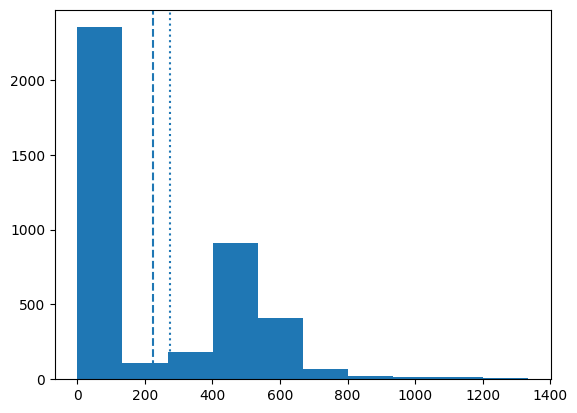

In [39]:
mean = np.mean(slice10)
fig, ax = plt.subplots()
ax.hist(slice10.flat)
ax.axvline(mean, linestyle='dashed')
p = ax.axvline(threshold, linestyle='dotted')

Dans quelle mesure cette stratégie de segmentation fonctionne-t-elle ?

On utilise le même code que celui utilisé précédemment, en créant un 
tableau de zéros et en remplaçant les zéros par des uns uniquement dans les 
parties du tableau qui correspondent aux pixels de l'image dont les valeurs 
sont inférieures au seuil.

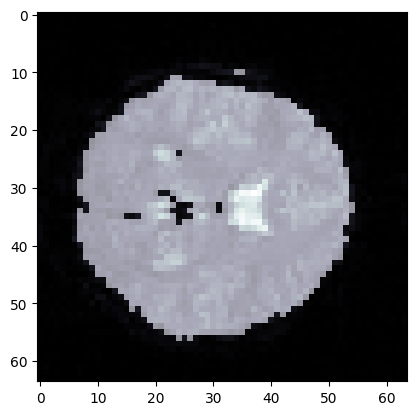

In [40]:
segmentation = np.zeros_like(slice10)
segmentation[slice10 > threshold] = 1

fig, ax = plt.subplots()
ax.imshow(slice10, cmap="bone")
p = ax.imshow(segmentation, alpha=0.5)

Cette segmentation est plutôt bonne. Il n’y a presque plus de voxels en dehors du cerveau qui sont classés à tort comme étant dans le cerveau. Mais on a toujours des problèmes avec les ventricules. Cela met en évidence la limite de cette méthode. En particulier, un seul seuil pourrait ne pas suffire. Dans l'exercice ci-dessous, il vous sera demandé de réfléchir davantage à ce problème.

Remarque: Dans la pratique on utilisera l'implémentation Scikit Image, qui se trouve au format skimage.filters.threshold_otsu. C'est beaucoup plus rapide et plus robuste que la simple implémentation décrite ci-dessus.

### Exemple avec Scikit Image

Votre valeur de seuil calculée. 0.3593252889677272


Text(0.5, 1.0, 'Intensity histogram')

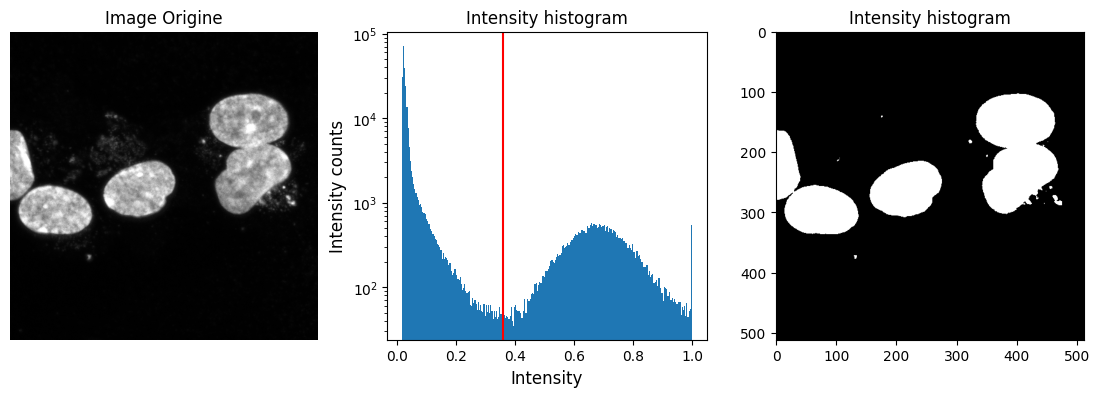

In [41]:
img = io.imread('MAX_BRCA1 C20 SCBT 50 and TBK1 A6 SCBT 100 ivt 4.tif')
#Convertir image en float.
img = img_as_float(img)
#index  des canaux individuels.
img_ch0 = img[:,:,0]
img_ch1 = img[:,:,1]
img_ch2 = img[:,:,2]

img = io.imread('MAX_BRCA1 C20 SCBT 50 and TBK1 A6 SCBT 100 ivt 4.tif')
#Convertir image en float.
img = img_as_float(img)
#index  des canaux individuels.
img_ch0 = img[:,:,0]
img_ch1 = img[:,:,1]
img_ch2 = img[:,:,2]

#Calcul seuil pour le premier canal de l'image.
thresh = threshold_otsu(img_ch0)
#Appliquer le seuil à l'image et générer une image binaire.
binary = img_ch0 > thresh
print('Votre valeur de seuil calculée.',thresh)
#Plotting
fig, ax = plt.subplots(1,3, figsize=(14, 4))


ax[0].imshow(img_ch0, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Image Origine", fontsize=12)
ax[1].hist(img_ch0.reshape(-1),bins=256)#Generate histogram.
ax[1].set_yscale("log")
ax[1].axvline(thresh, color='r')
ax[1].set_title("Intensity histogram", fontsize=12)
ax[1].set_ylabel("Intensity counts", fontsize=12)
ax[1].set_xlabel("Intensity", fontsize=12)
ax[2].imshow(binary, cmap="gray")
ax[2].set_title("Intensity histogram", fontsize=12)


#La ligne représente le seuil caulculé par  otsu.



#### Exercices

1.  En utilisant le code implémenté ci-dessus, implémentez un code qui trouve deux valeurs seuils pour segmenter la tranche de cerveau en trois segments différents. Cela permet-il de séparer correctement les ventricules des autres tissus cérébraux en fonction de leur intensité ? Comparez les performances de votre implémentation aux résultats de Scikit Image's `skimage.filters.threshold_multiotsu`.

2. Le module `skimage.filters` possède une fonction appelée `try_all_threshold`, qui compare plusieurs approches différentes de la segmentation basée sur les seuils. Exécutez cette fonction pour comparer les méthodes. Laquelle fonctionne le mieux sur cette image de cerveau ? Comment l'évalueriez-vous objectivement ?




### Segmentation Manuelle

On applique threshold_otsu deux fois : une fois pour les pixels d’intensité basse (en dessous de la médiane) et une autre pour ceux d’intensité élevée (au-dessus de la médiane). Cela génère deux seuils `thresh_low` et `thresh_high` pour diviser l’image en trois segments :
Pixels d’intensité faible (ventricules)
Pixels d’intensité moyenne (matière grise)
Pixels d’intensité élevée (matière blanche)


### Segmentation avec `threshold_multiotsu`

`threshold_multiotsu` calcule automatiquement deux seuils optimaux en divisant l’image en trois classes d’intensité.`threshold_multiotsu` utilise une approche statistique pour maximiser la séparation entre les différentes classes d’intensité.

### Analyse et Comparaison

La méthode manuelle peut être rapide mais dépend fortement de la médiane pour le choix des seuils, ce qui peut introduire des erreurs si les différentes régions d'intensité ne sont pas bien réparties.

Segmentation avec `threshold_multiotsu` : En règle générale, cette méthode est plus robuste pour segmenter les tissus car elle maximise les différences entre les classes d’intensité, offrant une séparation plus précise des structures cérébrales, y compris les ventricules.


***Référence*** https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_multiotsu.html 

 Seuil pour les valeurs basses 0.02087332866025788 
 Seuil pour les valeurs élevées 0.3697529528591592


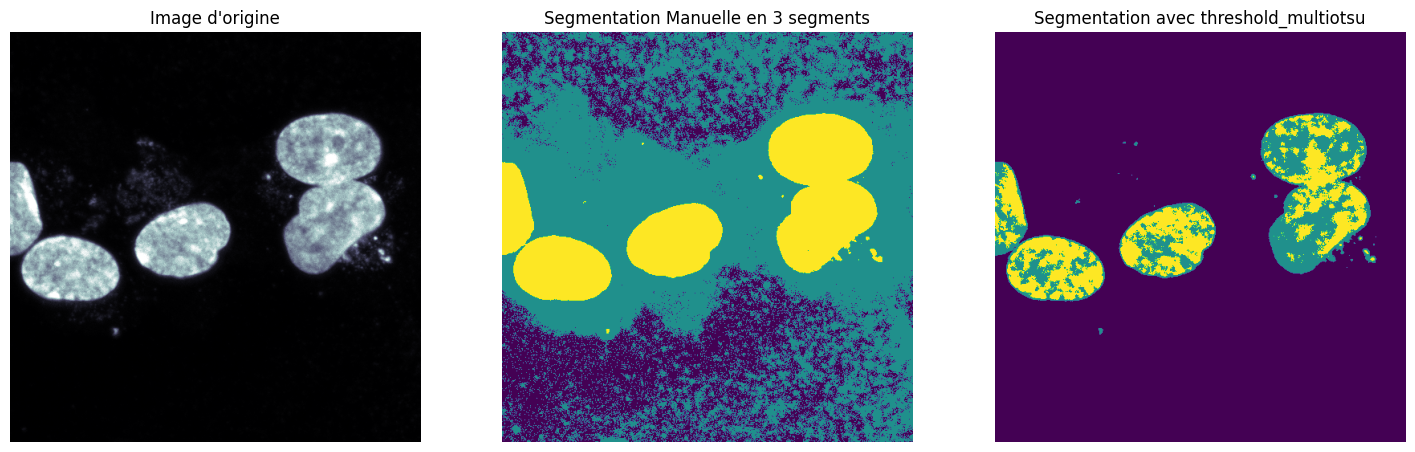

In [42]:


# Charger l'image et convertir en float
img = io.imread('MAX_BRCA1 C20 SCBT 50 and TBK1 A6 SCBT 100 ivt 4.tif')
img = img_as_float(img)
img_ch0 = img[:, :, 0]  # Utilisation du premier canal

# Méthode Manuelle pour trouver deux seuils
# Trouver le seuil de l'intensité médiane
thresh_low = threshold_otsu(img_ch0[img_ch0 < np.median(img_ch0)])  # Seuil pour les valeurs basses
thresh_high = threshold_otsu(img_ch0[img_ch0 >= np.median(img_ch0)])  # Seuil pour les valeurs élevées

print(f" Seuil pour les valeurs basses {thresh_low} \n Seuil pour les valeurs élevées {thresh_high}") 


# Appliquer les seuils pour segmenter l'image en trois segments
segmentation_manual = np.zeros_like(img_ch0)
segmentation_manual[img_ch0 <= thresh_low] = 0  # Segment 1 : Ventricules
segmentation_manual[(img_ch0 > thresh_low) & (img_ch0 <= thresh_high)] = 1  # Segment 2 : Matière grise
segmentation_manual[img_ch0 > thresh_high] = 2  # Segment 3 : Matière blanche

#  Utilisation de threshold_multiotsu de Scikit-Image pour la segmentation
thresholds_multiotsu = threshold_multiotsu(img_ch0, classes=3)
segmentation_multiotsu = np.digitize(img_ch0, bins=thresholds_multiotsu)

#print(thresholds_multiotsu[0])

#  Visualisation des résultats
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Image originale
ax[0].imshow(img_ch0, cmap="bone")
ax[0].set_title("Image d'origine")
ax[0].axis('off')

# Segmentation manuelle
ax[1].imshow(segmentation_manual, cmap="viridis")
ax[1].set_title("Segmentation Manuelle en 3 segments")
ax[1].axis('off')

# Segmentation avec threshold_multiotsu
ax[2].imshow(segmentation_multiotsu, cmap="viridis")
ax[2].set_title("Segmentation avec threshold_multiotsu")
ax[2].axis('off')

plt.show()


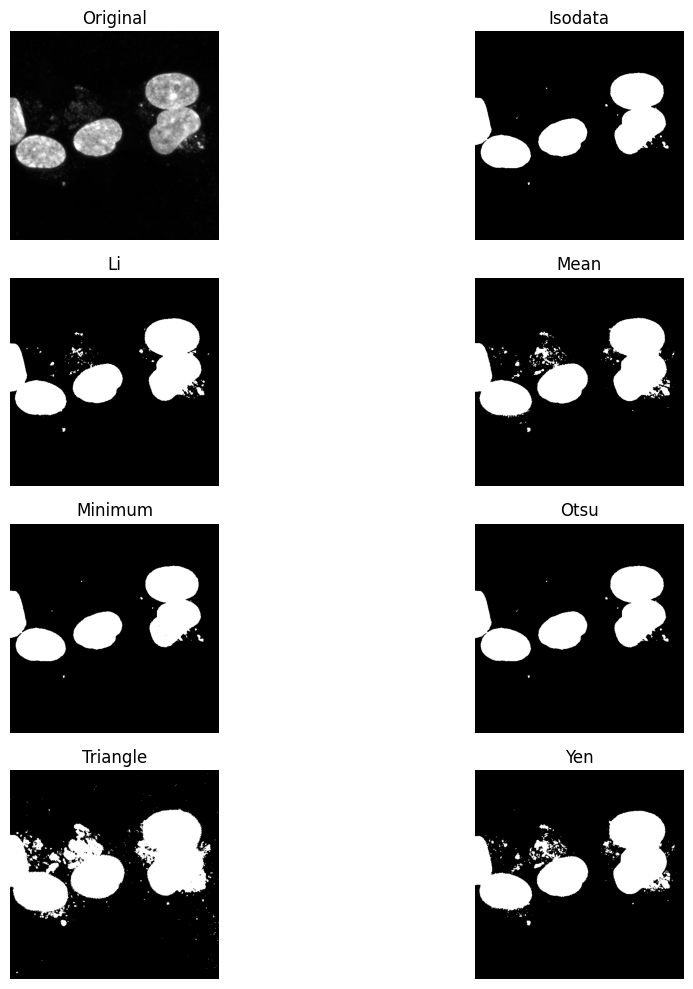

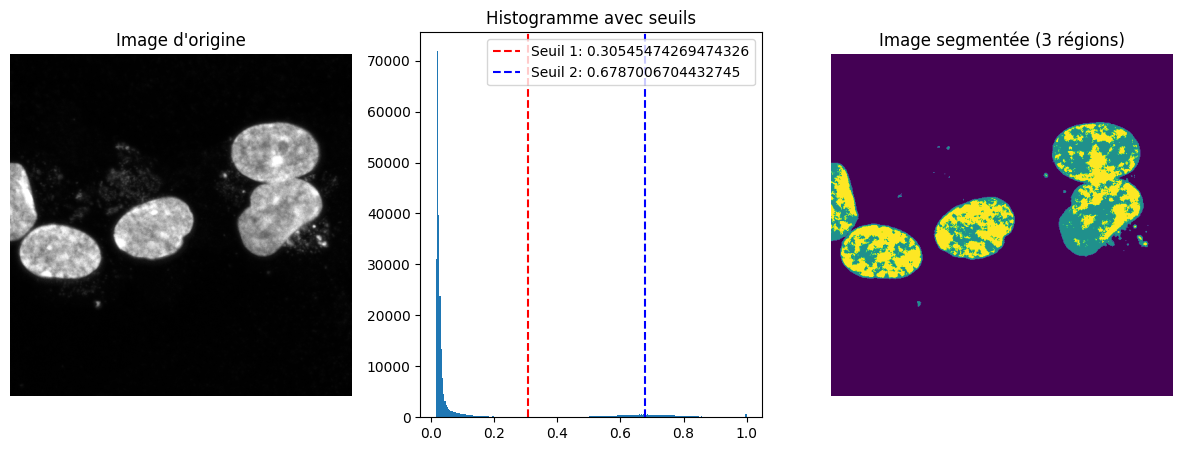

In [43]:


# Utilisation de try_all_threshold pour voir les différentes méthodes de segmentation
fig, ax = filters.try_all_threshold(img_ch0, figsize=(12, 10), verbose=False)
plt.show()


# Application des seuils pour créer trois segments
regions = np.digitize(img_ch0, bins=thresholds_multiotsu)

# Affichage des résultats
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Afficher l'image d'origine
ax[0].imshow(img_ch0, cmap="gray")
ax[0].set_title("Image d'origine")
ax[0].axis("off")

# Afficher les seuils superposés sur l'histogramme de l'image
ax[1].hist(img_ch0.ravel(), bins=256)
ax[1].axvline(thresholds_multiotsu[0], color='r', linestyle='--', label=f'Seuil 1: {thresholds_multiotsu[0]}')
ax[1].axvline(thresholds_multiotsu[1], color='b', linestyle='--', label=f'Seuil 2: {thresholds_multiotsu[1]}')
ax[1].set_title("Histogramme avec seuils")
ax[1].legend()

# Afficher l'image segmentée en trois régions
ax[2].imshow(regions, cmap="viridis")
ax[2].set_title("Image segmentée (3 régions)")
ax[2].axis("off")

plt.show()




1. **Isodata** :
    La méthode `Isodata` capture assez bien les régions les plus lumineuses des noyaux. Elle est assez simple et permet d’isoler les objets de contraste moyen, mais elle pourrait manquer de précision pour les détails fins autour des bords des objets.

2. **Li** :
    La méthode `Li` est généralement efficace pour segmenter les objets dans des images avec des variations de luminosité. Elle parvient à distinguer les régions de noyaux de manière assez nette, mais elle peut introduire plus de bruit dans le fond, ce qui peut réduire la précision si une isolation plus propre est nécessaire.

3. **Mean (Moyenne)** :
    Le seuillage par moyenne est une approche simple, mais elle semble inclure plus de bruit de fond. Ce n'est pas idéal pour ces images, car cette méthode ne s'adapte pas bien aux variations d'intensité plus faibles.

4. **Minimum** :
    Cette méthode identifie relativement bien les noyaux mais peut rencontrer des difficultés avec le bruit lorsque d’autres zones lumineuses sont présentes en arrière-plan. Elle repose sur les minima de l’histogramme, ce qui peut être problématique s'il y a plusieurs pics d’intensité.

5. **Otsu** :
    La méthode `Otsu` est souvent très efficace, car elle cherche à maximiser la variance inter-classes. Ici, elle réussit bien à isoler les noyaux, bien qu’elle puisse inclure des régions supplémentaires autour des bords des objets. C'est une méthode fréquemment utilisée pour la segmentation binaire et elle fonctionne bien dans les images avec des histogrammes bimodaux.

6. **Triangle** :
    La méthode `Triangle` est efficace lorsque l'image présente un pic d’intensité marqué. Elle semble donner un résultat correct ici, bien qu'elle inclue parfois du bruit de fond non désiré.

7. **Yen** :
    La méthode `Yen` fonctionne en maximisant l'entropie et peut être plus adaptée aux images ayant un contraste bien marqué entre l'arrière-plan et l'avant-plan. Elle semble capturer les noyaux correctement, mais peut inclure plus de bruit de fond.

### Comparaison et Évaluation

Pour évaluer ces méthodes de manière objective, il serait idéal de disposer d'une **segmentation de référence** (ou "ground truth") pour comparer chaque méthode en utilisant des métriques comme le **coefficient de similarité de Dice** ou l'**Intersection sur Union (IoU)**. En comparant visuellement :

 **Meilleurs choix** : Les méthodes `Otsu`, `Isodata` et `Li` offrent de bons résultats, capturant la majorité des noyaux sans trop de bruit de fond.
 **Moins efficaces** : Les méthodes `Mean` (moyenne) et `Triangle` semblent moins adaptées, car elles incluent plus d’artefacts en arrière-plan.



 ***Référence:*** https://scikit-image.org/docs/stable/api/skimage.filters.html